In [1]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
import h5py
from mce.core import ScenarioBase
from mce.core.driver import DriverBase
from mce.core.forcing_ar6 import RfAllAR6
from mce.util.plot_base import PlotBase

In [2]:
myplt = PlotBase(palette='ipcc_wg1')

## Construct a historical "best" scenario

In [75]:
ds = ScenarioBase()
scenario = 'historical_best'
grp = ds.file.create_group(f'{scenario}/input')

[2025-03-28 11:35:33 mce.core] INFO:in-memory file opened


### Copy timeseries from the current scenario DB

In [76]:
ds_in = ScenarioBase(outpath='untracked/scenarios.h5', mode='r')

for cat, gsrc in ds_in.file['historical/input'].items():
    print(cat)
    gdest = ds.file[f'{scenario}/input'].create_group(cat)

    for k, v in gsrc.items():
        dset = gdest.create_dataset(k, data=v[:])
        dset.attrs['units'] = v.attrs['units']

ds_in.close()

[2025-03-28 11:35:35 mce.core] INFO:untracked/scenarios.h5 already exists
[2025-03-28 11:35:35 mce.core] INFO:file untracked/scenarios.h5 opened with mode=r


[2025-03-28 11:35:36 mce.core] INFO:file untracked/scenarios.h5 closed


conc
emis_co2
emis_ghg
emis_natural
emis_slcf
erf_other


In [ ]:
# combine land_use and irrigation 
grp = ds.file[f'{scenario}/input/erf_other']
grp['land_use'][:] = grp['land_use'][:] + grp['irrigation'][:]
del grp['irrigation']

In [86]:
list(grp)

['contrails', 'land_use', 'solar', 'time', 'volcanic']

### Make ERF best estimate for all forcing categories

Same as in `mk_forcing_ar6__02.ipynb`

In [88]:
grp = ds.file[f'{scenario}/input/conc']
df_conc = pd.DataFrame({
    k: v[:] for k, v in grp.items()
}).set_index('time')
df_conc

,C2F6,C3F8,C7F16,C8F18,CCl4,CF4,CFC-11,CFC-112,CFC-112a,CFC-113,...,Halon-2402,N2O,NF3,SF6,SO2F2,c-C4F8,i-C6F14,n-C4F10,n-C5F12,n-C6F14
time,,,,,,,,,,,,,,,,,,,,,
1750,0.000001,0.00,0.00000,0.000,0.025,34.05,0.0,0.0,0.0000,0.00,...,0.0,270.10,0.0,0.000,0.000021,0.0000,0.0000,0.0000,0.0000,0.0000
1751,0.000001,0.00,0.00000,0.000,0.025,34.05,0.0,0.0,0.0000,0.00,...,0.0,270.12,0.0,0.000,0.000021,0.0000,0.0000,0.0000,0.0000,0.0000
1752,0.000001,0.00,0.00000,0.000,0.025,34.05,0.0,0.0,0.0000,0.00,...,0.0,270.14,0.0,0.000,0.000021,0.0000,0.0000,0.0000,0.0000,0.0000
1753,0.000001,0.00,0.00000,0.000,0.025,34.05,0.0,0.0,0.0000,0.00,...,0.0,270.16,0.0,0.000,0.000021,0.0000,0.0000,0.0000,0.0000,0.0000
1754,0.000001,0.00,0.00000,0.000,0.025,34.05,0.0,0.0,0.0000,0.00,...,0.0,270.18,0.0,0.000,0.000021,0.0000,0.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020,4.940000,0.70,0.11984,0.097,77.000,86.40,223.9,0.4,0.0704,69.20,...,0.4,333.30,2.3,10.270,2.600000,1.8114,0.0690,0.2073,0.1528,0.2312
2021,5.030000,0.72,0.12132,0.098,76.000,87.40,221.6,0.4,0.0712,68.60,...,0.4,334.60,2.5,10.650,2.700000,1.8742,0.0704,0.2114,0.1564,0.2328
2022,5.150000,0.74,0.12280,0.099,75.000,88.50,219.3,0.4,0.0720,68.10,...,0.4,335.90,2.7,11.040,2.800000,1.9370,0.0718,0.2155,0.1600,0.2344


In [89]:
grp = ds.file[f'{scenario}/input/emis_slcf']
df_emis_slcf = pd.DataFrame({
    k: v[:] for k, v in grp.items()
}).set_index('time')
df_emis_slcf

,BC,CO,NH3,NMVOC,NOx,OC,SO2
time,,,,,,,
1750,2.100870,348.399852,6.621229,60.850611,19.416307,15.456225,2.337203
1751,2.076098,343.798326,6.552572,59.919860,19.196908,15.197454,2.302926
1752,2.067556,341.680443,6.510804,59.466680,19.199636,15.043393,2.289829
1753,2.075267,343.546330,6.571654,59.863982,19.115865,15.191642,2.301855
1754,2.102739,349.685949,6.704298,61.110528,19.264324,15.568049,2.351538
...,...,...,...,...,...,...,...
2020,7.053568,743.096178,66.876988,194.037504,129.891272,29.284582,71.841721
2021,7.284025,801.271591,68.769249,206.454099,133.112074,33.993504,75.164860
2022,6.763899,680.561399,67.194197,182.672416,130.279514,25.486932,75.262487


In [90]:
forcing = RfAllAR6(df_emis_slcf, df_conc)

In [91]:
# Calibrated parameters for aerosol and ozone forcing
with h5py.File('untracked/datain.h5', 'r') as h5f:
    grp = h5f['ClimateIndicator-2024/forcing-timeseries']

    gin = grp['ari_emitted']
    df = pd.DataFrame(
        {k: v[:] for k, v in gin.items()},
        index=gin.attrs['species'],
    )
    forcing.init__ari(df['mean'], df['sd'])

    gin = grp['aci_cal']
    df = pd.DataFrame(
        {k: v[:] for k, v in gin.items()},
        index=gin.attrs['models'],
    )
    forcing.init__aci(df)

    gin = grp['timeseries/temp_obs']
    args = [pd.Series(gin['value'][:], index=gin['year'][:])]

    for k in ['trop', 'strat']:
        gin = grp[f'skeie_ozone_{k}']
        args.append(
            pd.DataFrame(
                gin['value'][:],
                index=gin.attrs['index_model'],
                columns=gin.attrs['columns_year'],
            )
        )

    forcing.init__o3(*args)

In [92]:
grp = ds.file[f'{scenario}/input'].create_group('erf')
dset = grp.create_dataset('time', data=df_conc.index.values)
dset.attrs['units'] = 'yr'

In [93]:
units = 'W m-2'

# CO2, CH4, and N2O
for k, v in forcing.erf__ghg_major(df_conc).items():
    dset = grp.create_dataset(k, data=v.values)
    dset.attrs['units'] = units

# Aggregated halogenated species
k = 'halogen'
v = forcing.erf__ghg_minor(df_conc).sum(axis=1)
dset = grp.create_dataset(k, data=v.values)
dset.attrs['units'] = units

In [94]:
# aerosol-radiation_interactions
k = 'ari'
v = forcing.erf__ari(df_emis_slcf, df_conc)
dset = grp.create_dataset(k, data=v.values)
dset.attrs['units'] = units

In [95]:
# aerosol-cloud_interactions
k = 'aci'
v = forcing.erf__aci(df_emis_slcf)
dset = grp.create_dataset(k, data=v.values)
dset.attrs['units'] = units

In [96]:
# O3
k = 'o3'
v = forcing.erf__o3(df_emis_slcf, df_conc)
dset = grp.create_dataset(k, data=v.values)
dset.attrs['units'] = units

In [97]:
# BC_on_snow
k = 'bc_on_snow'
d1 = df_emis_slcf['BC']
v = forcing.bc_on_snow__factor * (d1 - d1.loc[1750])
dset = grp.create_dataset(k, data=v.values)
dset.attrs['units'] = units

In [98]:
# H2O_stratospheric
k = 'h2o_strat'
d1 = df_conc['CH4']
v = forcing.h2o_strat__factor * (d1 - d1.loc[1750])
dset = grp.create_dataset(k, data=v.values)
dset.attrs['units'] = units

In [101]:
# merged with the other categories
for k, v in ds.file[f'{scenario}/input/erf_other'].items():
    if k == 'time':
        continue
    print(k)
    dset = grp.create_dataset(k, data=v[:])
    dset.attrs['units'] = units

contrails
land_use
solar
volcanic


In [102]:
del ds.file[f'{scenario}/input/erf_other']

### Check if the total is equal to the original

In [103]:
from mce.util.io import RetrieveGitHub
repo = RetrieveGitHub('ClimateIndicator', 'forcing-timeseries', 'datain')

path = repo.retrieve('output/ERF_best_1750-2024.csv')
erf_best_ref = pd.read_csv(path, index_col=0)

path = repo.retrieve('output/ERF_best_aggregates_1750-2024.csv')
erf_best_agg_ref = pd.read_csv(path, index_col=0).rename(int)

np.allclose(
    pd.DataFrame({
        k: v for k, v in ds.file['historical_best/input/erf'].items()
    }).set_index('time').sum(axis=1),
    erf_best_ref.sum(axis=1),
)

[2025-03-28 11:56:13 mce.util.io] INFO:Use local file datain/ClimateIndicator/forcing-timeseries/output/ERF_best_1750-2024.csv retrieved from https://github.com/ClimateIndicator/forcing-timeseries/raw/main/output/ERF_best_1750-2024.csv on 2025-03-11
[2025-03-28 11:56:13 mce.util.io] INFO:Use local file datain/ClimateIndicator/forcing-timeseries/output/ERF_best_aggregates_1750-2024.csv retrieved from https://github.com/ClimateIndicator/forcing-timeseries/raw/main/output/ERF_best_aggregates_1750-2024.csv on 2025-03-11


True

## Driver

In [26]:
class Driver(DriverBase):
    def preproc_add(self):
        """Scenario-dependent preprocessing
        """
        if 'ocean' in self.map_y:
            cfg = self.save['ocean']
            din = self.din['conc']
            cfg['iloc_co2'] = din['variables'].index('CO2')

        if 'gascycle' in self.map_y:
            din = self.din['emis_ghg']
            din_nat = self.din['emis_natural']
            cfg = self.save['gascycle']

            cfg['iloc'] = np.array([
                din['variables'].index(gas)
                for gas in cfg['ghg_order']
            ])
            cfg['iloc_nat'] = np.array([
                cfg['ghg_order'].index(gas)
                for gas in din_nat['variables']
                if gas in cfg['ghg_order']
            ])
            cfg['iloc_nat_src'] = np.array([
                i for i, gas in enumerate(din_nat['variables'])
                if gas in cfg['ghg_order']
            ])

            gases = [
                gas for gas in cfg['ghg_order'] if gas not in ['CH4', 'N2O']  
            ]
            cfg['halogen_order'] = gases
            cfg['halogen_pi'] = self.forcing.conc_pi.reindex(gases)
            cfg['halogen_eff'] = self.forcing.ghg__hc_eff.reindex(gases)

            if hasattr(self, 'year_base'):
                din = self.din['conc']
                conc = pd.DataFrame(
                    din['data'], index=din['time'], columns=din['variables'],
                ).loc[self.year_base]

                cfg['erf_base_ghg'] = self.forcing.erf__ghg_major(conc)

                if cfg['halogen_order']:
                    cfg['erf_base_halogen'] = (
                        (conc[cfg['halogen_order']] - cfg['halogen_pi'])
                        * cfg['halogen_eff']
                    ).sum()

        # to be updated in erf_in()
        self.save['forcing'] = {'erfcat': None}

    def emis_co2_in(self, t):
        """Distinguish AFOLU emissions from FFI emissions
        based on a given scenario

        AFOLU=Agriculture, Forestry and Other Land Use
        FFI=Fossil Fuel combustion and Industrial processes

        Parameters
        ----------
        t
            Time point in year

        Returns
        -------
            Emission rates in Gt C yr-1 from FFI and AFOLU
            and cumulative emissions in Gt C from AFOLU
            at the time point
        """
        din = self.din['emis_co2']
        emis = dict(zip(din['variables'], din['interp'](t)))

        din = self.din['ecum_co2']
        ecum = dict(zip(din['variables'], din['interp'](t)))

        return emis, ecum

    def emis_ghg_in(self, t):
        """Non-CO2 GHG emissions

        Parameters
        ----------
        t
            Time point in year

        Returns
        -------
            Emission rates at the time
            Mt <gas> yr-1 for CH4 and N2O
            or kt <gas> yr-1 for halogenated species
        """
        din = self.din['emis_ghg']
        din_nat = self.din['emis_natural']
        cfg = self.save['gascycle']

        emis = din['interp'](t)[cfg['iloc']]
        if len(cfg['iloc_nat']):
            emis[cfg['iloc_nat']] += din_nat['interp'](t)[cfg['iloc_nat_src']]

        return emis

    def conc_co2_in(self, t):
        """Evaluate CO2 concentration based on a given scenario
        to be used for concentration-driven runs

        Parameters
        ----------
        t
            Time point in year

        Returns
        -------
            CO2 concentration in ppm at the time point
        """
        din = self.din['conc']
        cfg = self.save['ocean']
        return din['interp'](t)[cfg['iloc_co2']]

    def conc_co2_full_in(self):
        """Get time series of input CO2 concentration
        to be used for concentration-driven runs

        Returns
        -------
            Time series of CO2 concentration in ppm
            from a given scenario
        """
        din = self.din['conc']
        cfg = self.save['ocean']
        return din['data'][:, cfg['iloc_co2']]

    def erf_in(self, t, y):
        """Evaluate forcing based on a given scenario

        Parameters
        ----------
        t
            Time point in year
        y
            Value of each prediction variable at the time point

        Returns
        -------
            Forcing in W m-2 at the time point
        """
        din = self.din['erf']
        # categorized forcing from scenario data
        erfcat = pd.Series(dict(zip(din['variables'], din['interp'](t))))

        is_cdrv = self.save['ocean']['is_cdrv']

        if is_cdrv:
            cco2 = self.conc_co2_in(t)

        else:
            nl = len(self.climate.parms.tauj)
            takj = y[self.map_y['climate']].reshape((nl, nl))
            tas = takj[0, :].sum()

            coc = y[self.map_y['ocean']]
            model = self.ocean
            hls = model.parms.hlk[0]
            catm = model.partit(coc[0], hls, tas)
            cco2 = catm * model.parms.alphaa + model.parms.cco2_pi

        # CO2 forcing is replaced with that computed
        erfcat['CO2'] = self.forcing.c2erf(cco2)

        if 'gascycle' in self.map_y:
            # the other well-mixed GHG forcing is replaced
            # if configured as such
            cfg = self.save['gascycle']
            conc = pd.Series(dict(zip(
                cfg['ghg_order'], y[self.map_y['gascycle']],
            )))
            # add CO2 for overlap in absorption spectra
            conc['CO2'] = cco2
            erf_ghg = (
                self.forcing.erf__ghg_major(conc)
                - cfg.get('erf_base_ghg', 0.)
            )
            for gas in ['CH4', 'N2O']:
                if gas in erf_ghg:
                    erfcat[gas] = erf_ghg[gas]

            if cfg['halogen_order']:
                erfcat['halogen'] = (
                    (conc[cfg['halogen_order']] - cfg['halogen_pi'])
                    * cfg['halogen_eff']
                ).sum() - cfg.get('erf_base_halogen', 0.)

        # use scenario data for the other categorized forcing:
        # 'aci', 'ari', 'o3',
        # 'h2o_strat', 'contrails', 'bc_on_snow', 'land_use',
        # 'solar', and 'volcanic'

        self.save['forcing']['erfcat'] = erfcat

        return erfcat.sum()

    def postproc(self, **out):
        data = super().postproc(**out)

        df = pd.DataFrame(data).set_index('time').rename_axis(None)
        j0 = df.shape[1]

        # add total and categorized ERF
        columns = ['erf', 'erf|non-CO2'] + [
            f'erf|{cat}' for cat in self.save['forcing']['erfcat'].index
        ]
        df = df.reindex(df.columns.tolist() + columns, axis=1)

        for n, t in enumerate(self.time):
            df.iloc[n, j0] = self.erf_in(t, self.sol.y[:, n])
            df.iloc[n, j0+2:] = self.save['forcing']['erfcat'].values

        df.loc[:, 'erf|non-CO2'] = df.loc[:, 'erf'] - df.loc[:, 'erf|CO2']

        # add cumulative CO2 emissions
        df_add = pd.DataFrame(
            self.din['ecum_co2']['interp'](self.time),
            index=[f'ecum|{x}' for x in self.din['ecum_co2']['variables']],
            columns=self.time,
        ).T

        return pd.concat([df, df_add], axis=1)

## Configuration

### Use model parameters calibrated to CMIP6 MIROC-ES2L

In [27]:
parmdata = 'untracked/parms_calib.h5'
calib_set = [
    'climate/norm1__nl3',
    'ocean/BGC_step-4__rev4a',
    'land/BGC_step-4__rev4a',
]
parms = {}

with h5py.File(parmdata, mode='r') as h5f:
    for calib in calib_set:
        grp = h5f[f'CMIP6/MIROC-ES2L/{calib}']
        parms[calib] = {k: v for k, v in grp.attrs.items()}

In [28]:
with h5py.File(parmdata, mode='r') as h5f:
    grp = h5f[f'CMIP6/MIROC-ES2L/ocean/BGC_step-4__rev4a']
    kw_ocean = {k: v for k, v in grp.attrs.items()}
    grp = h5f[f'CMIP6/MIROC-ES2L/land/BGC_step-4__rev4a']
    kw_land = {k: v for k, v in grp.attrs.items()}

In [29]:
with h5py.File(parmdata, mode='r') as h5f:
    grp = h5f[f'CMIP6/MIROC-ES2L/climate/norm1__nl3']
    p1 = {k: v for k, v in grp.attrs.items()}

kw_irm = {
    'asj': np.array([p1[f'a{j}'] for j in range(3)]),
    'tauj': np.array([p1[f'tau{j}'] for j in range(3)]),
    'lamb': p1['lambda'],
}
kw_rfall = {
    'alpha': p1['co2_alpha'],
    'beta': p1['co2_beta'],
}

### Set base year to 1850 instead of 1750

In [30]:
year_base = 1850
cco2_pi = df_conc.loc[year_base, 'CO2']
kw_ocean['cco2_pi'] = cco2_pi
kw_rfall['ccref'] = cco2_pi
cco2_pi

285.583545

In [113]:
grp = ds.file[f'{scenario}/input/erf']
i0 = np.where(grp['time'][:]==year_base)[0][0]

In [116]:
(
    pd.DataFrame({k: v[:] for k, v in grp.items()})
    .set_index('time').iloc[i0-5:i0+6]
)

,CH4,CO2,N2O,aci,ari,bc_on_snow,contrails,h2o_strat,halogen,land_use,o3,solar,volcanic
time,,,,,,,,,,,,,
1845,0.046979,0.133112,0.006992,-0.054426,-0.004793,0.006037,0.0,0.003275,7.560109e-08,-0.036778,0.022321,-0.054250,0.126957
1846,0.047461,0.134497,0.007065,-0.052482,-0.003812,0.006053,0.0,0.003309,7.639689e-08,-0.037514,0.022345,-0.041879,-0.434533
1847,0.047941,0.135883,0.007139,-0.059780,-0.004615,0.006832,0.0,0.003344,7.719269e-08,-0.038251,0.023560,-0.029539,-0.004275
1848,0.048422,0.137267,0.007212,-0.068310,-0.005984,0.007683,0.0,0.003378,7.798849e-08,-0.038987,0.025183,-0.017168,0.196899
1849,0.048902,0.138652,0.007285,-0.066219,-0.005828,0.007336,0.0,0.003413,7.878429e-08,-0.039723,0.024639,-0.004796,0.237356
1850,0.049382,0.140036,0.007358,-0.069023,-0.006168,0.007634,0.0,0.003447,7.958010e-08,-0.040767,0.025046,0.007528,0.244142
1851,0.049486,0.142379,0.007656,-0.062485,-0.004940,0.006985,0.0,0.003455,8.228277e-08,-0.042118,0.024016,0.002068,0.245039
1852,0.049947,0.145029,0.007953,-0.059937,-0.004413,0.006716,0.0,0.003488,8.533412e-08,-0.043470,0.023625,0.001257,0.245011
1853,0.050708,0.147408,0.008331,-0.063313,-0.004926,0.007034,0.0,0.003543,8.839851e-08,-0.044821,0.024263,-0.008868,-0.001430


In [118]:
# make ERF relative to 1850 for each category except for volcanic
for k, v in grp.items():
    if k in ['time', 'volcanic']:
        continue
    v[:] = v[:] - v[i0]

In [119]:
(
    pd.DataFrame({k: v[:] for k, v in grp.items()})
    .set_index('time').iloc[i0-5:i0+6]
)

,CH4,CO2,N2O,aci,ari,bc_on_snow,contrails,h2o_strat,halogen,land_use,o3,solar,volcanic
time,,,,,,,,,,,,,
1845,-0.002403,-0.006924,-0.000366,0.014597,0.001375,-0.001597,0.0,-0.000172,-3.979005e-09,0.003989,-0.002725,-0.061778,0.126957
1846,-0.001922,-0.005539,-0.000293,0.016541,0.002356,-0.001581,0.0,-0.000138,-3.183204e-09,0.003253,-0.002701,-0.049407,-0.434533
1847,-0.001441,-0.004154,-0.000220,0.009243,0.001553,-0.000802,0.0,-0.000103,-2.387403e-09,0.002517,-0.001485,-0.037067,-0.004275
1848,-0.000960,-0.002769,-0.000146,0.000714,0.000183,0.000049,0.0,-0.000069,-1.591602e-09,0.001780,0.000137,-0.024696,0.196899
1849,-0.000480,-0.001384,-0.000073,0.002804,0.000340,-0.000298,0.0,-0.000034,-7.958010e-10,0.001044,-0.000407,-0.012324,0.237356
1850,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.244142
1851,0.000103,0.002343,0.000298,0.006539,0.001227,-0.000649,0.0,0.000007,2.702677e-09,-0.001351,-0.001030,-0.005460,0.245039
1852,0.000564,0.004993,0.000595,0.009087,0.001755,-0.000918,0.0,0.000041,5.754020e-09,-0.002703,-0.001421,-0.006271,0.245011
1853,0.001326,0.007372,0.000973,0.005710,0.001242,-0.000600,0.0,0.000095,8.818414e-09,-0.004054,-0.000782,-0.016396,-0.001430


### Add cumulative AFOLU emissions

In [ ]:
# Use AFOLU emissions implied from MIROC-ES2L runs,
# subject to considerable uncertainty,
# based on Hajima et al. (2025, Biogeosciences, https://doi.org/10.5194/bg-22-1447-2025)
with h5py.File('untracked/scenarios.h5', mode='r') as h5f:
    grp = h5f[f'historical/CMIP6/MIROC-ES2L/ecum_co2']
    d1 = pd.Series(grp['AFOLU'], index=grp['time'])

# Extraporate the data to 2024
interp = interp1d(d1.loc[1970:].index, d1.loc[1970:])
xref = interp.x[[0, -1]]
yref = interp(xref)
slope = (yref[1] - yref[0]) / (xref[1] - xref[0])
x_ext = np.arange(d1.index[-1] + 1, 2024 + 1)
y_ext = slope * (x_ext - xref[0]) + yref[0]

In [121]:
# Add the data to the input scenario
grp = ds.file[f'{scenario}/input'].create_group('ecum_co2')

# including initial zero
time = np.hstack([d1.index[0]-0.5, d1.index, x_ext])
data = np.hstack([0., d1, y_ext]) # including initial zero

dset = grp.create_dataset('time', data=time)
dset.attrs['units'] = 'yr'
dset = grp.create_dataset('AFOLU', data=data)
dset.attrs['units'] = 'Gt C'

In [122]:
# original CO2 emissions after 1850
grp = ds.file[f'{scenario}/input/emis_co2']

df_emis_co2_ref = pd.DataFrame({
    k: v[:] for k, v in grp.items()
}).set_index('time').loc[year_base:]
df_emis_co2_ref

,AFOLU,FFI
time,,
1850,0.720145,0.053725
1851,0.769573,0.054252
1852,0.779884,0.056658
1853,0.793014,0.059290
1854,0.795534,0.069607
...,...,...
2020,0.938591,9.586934
2021,0.969646,10.095998
2022,0.966441,10.178449


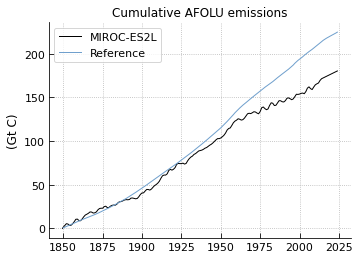

In [123]:
myplt.init_regular()
ax = myplt(0)

grp = ds.file[f'{scenario}/input/ecum_co2']
ax.plot(grp['time'][:], grp['AFOLU'][:], label='MIROC-ES2L')

d1 = df_emis_co2_ref['AFOLU'].cumsum()
ax.plot(d1.index, d1, label='Reference')

ax.legend()
ax.set_title('Cumulative AFOLU emissions')
ax.set_ylabel('({})'.format(grp['AFOLU'].attrs['units']))
ax.grid()

### Replace AFOLU emissions with the model-based data

In [ ]:
grp = ds.file[f'{scenario}/input']

#  derive annual emissions from cumulative emissions
d1 = pd.Series(grp['ecum_co2/AFOLU'], index=grp['ecum_co2/time'])
kw_interp = {'bounds_error': False, 'fill_value': 'extrapolate'}
interp = interp1d(d1.index, d1, **kw_interp)

time = df_emis_co2_ref.index.values
data = interp(time + 0.5) - interp(time - 0.5)

In [131]:
# update emission data
grp['emis_co2'].clear()

dset = grp['emis_co2'].create_dataset('time', data=time)
dset.attrs['units'] = 'yr'

units = 'Gt C yr-1'
# model-based AFOLU emissions
dset = grp['emis_co2'].create_dataset('AFOLU', data=data)
dset.attrs['units'] = units

# original FFI emissions
dset = grp['emis_co2'].create_dataset('FFI', data=df_emis_co2_ref['FFI'].values)
dset.attrs['units'] = units

### Initial values

In [132]:
config = {comp: {} for comp in ['climate', 'ocean', 'land']}
# not specified, to be set to zero

# ensure emission-driven mode
config['ocean']['is_cdrv'] = False

# all non-CO2 GHGs
gas_order_all = [
    'CH4', 'N2O',
    # chlorofluorocarbons (CFC), hydrofluorochlorocarbons (HCFC),
    # chlorocarbons, hydrochlorocarbons,
    # bromocarbons, hydrobromocarbons, and halons
    'CFC-11', 'CFC-112', 'CFC-112a', 'CFC-113', 'CFC-113a', 'CFC-114',
    'CFC-114a', 'CFC-115', 'CFC-12', 'CFC-13', 'CH2Cl2',
    'CH3Br', 'CH3CCl3', 'CH3Cl', 'CHCl3',
    'HCFC-124', 'HCFC-133a', 'HCFC-141b', 'HCFC-142b', 'HCFC-22', 'HCFC-31',
    'Halon-1211', 'Halon-1301', 'Halon-2402',
    # hydrofluorocarbons (HFC) and fully fluorinated species including perfluorocarbons (PFCs)
    'HFC-125', 'HFC-134a', 'HFC-143a', 'HFC-152a', 'HFC-227ea', 'HFC-23',
    'HFC-236fa', 'HFC-245fa', 'HFC-32', 'HFC-365mfc', 'HFC-43-10mee',
    'NF3', 'C2F6', 'C3F8', 'n-C4F10', 'n-C5F12', 'n-C6F14', 'i-C6F14',
    'C7F16', 'C8F18', 'CF4', 'c-C4F8', 'SF6', 'SO2F2', 'CCl4',
]
# selected GHGs
# gas_order_selected = ['CH4', 'N2O', 'CFC-11', 'CFC-12', 'CH3Cl', 'HFC-134a']
gas_order_selected = ['CH4', 'N2O']

# use all 49 GHGs
gas_order = gas_order_all
config['gascycle'] = {
    # initial values
    gas: df_conc.loc[year_base, gas] for gas in gas_order
}

## Run

In [133]:
kw_all = {
    'kw_irm': kw_irm,
    # 'kw_rfall': kw_rfall, # used later
    'kw_ocean': kw_ocean,
    'kw_land': kw_land,
}
drv = Driver(**{**kw_all, **config})

# replace forcing module with that including AR6-based full-emission schemes
drv.forcing = RfAllAR6(df_emis_slcf, df_conc, **kw_rfall)

# set base year for the custom driver
drv.year_base = year_base

In [134]:
din = ds.get_scenario('historical_best')
# 2024 data still not available for CH4 and N2O
time = np.arange(year_base, 2023+1)
ret = drv.run(din, time)

In [135]:
ret

,tas,thc,cbst,ghg|CH4,ghg|N2O,ghg|CFC-11,ghg|CFC-112,ghg|CFC-112a,ghg|CFC-113,ghg|CFC-113a,...,erf|ari,erf|bc_on_snow,erf|contrails,erf|h2o_strat,erf|halogen,erf|land_use,erf|o3,erf|solar,erf|volcanic,ecum|AFOLU
1850,0.000000,0.000000,0.000000,807.600000,272.100000,0.000000,0.000000,0.0000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.244142,1.406691
1851,0.041775,3.540400,-2.165499,808.559172,272.166056,0.000000,0.000000,0.0000,0.000000,0.000000,...,0.001227,-0.000649,0.000000,0.000007,2.180036e-09,-0.001351,-0.001030,-0.005460,0.245039,3.413809
1852,0.062437,6.620677,-3.394789,809.493467,272.239043,0.000000,0.000000,0.0000,0.000000,0.000000,...,0.001755,-0.000918,0.000000,0.000041,5.102355e-09,-0.002703,-0.001421,-0.006271,0.245011,5.496448
1853,0.049823,7.539020,-3.077544,810.533353,272.321189,0.000000,0.000000,0.0000,0.000000,0.000000,...,0.001242,-0.000600,0.000000,0.000095,8.172203e-09,-0.004054,-0.000782,-0.016396,-0.001430,5.062429
1854,-0.001536,4.556509,-2.058295,811.846611,272.415486,0.000000,0.000000,0.0000,0.000000,0.000000,...,-0.000820,0.000625,0.000000,0.000154,1.125342e-08,-0.005405,0.001181,-0.030250,-0.282578,3.492822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019,1.095737,424.689145,43.775858,1872.129981,332.319138,226.031560,0.400010,0.0696,69.792909,0.899725,...,-0.235286,0.072366,0.061541,0.046553,4.079128e-01,-0.149866,0.456536,-0.029701,0.108443,175.871243
2020,1.115209,440.072884,45.549277,1882.901088,333.425320,223.912085,0.400010,0.0704,69.202181,0.999730,...,-0.189636,0.066413,0.030676,0.047098,4.088151e-01,-0.150400,0.440494,-0.024497,0.074220,176.758025
2021,1.144609,456.317360,47.305595,1893.782793,334.562293,221.612555,0.400010,0.0712,68.627206,1.099735,...,-0.215908,0.069859,0.036909,0.047841,4.096675e-01,-0.150647,0.454836,0.012029,0.132409,177.644807
2022,1.190167,474.173794,49.035219,1905.856031,335.715351,219.312316,0.400010,0.0720,68.101892,1.199740,...,-0.192009,0.062083,0.046870,0.048553,4.104112e-01,-0.150835,0.449455,0.051865,0.171705,178.531589


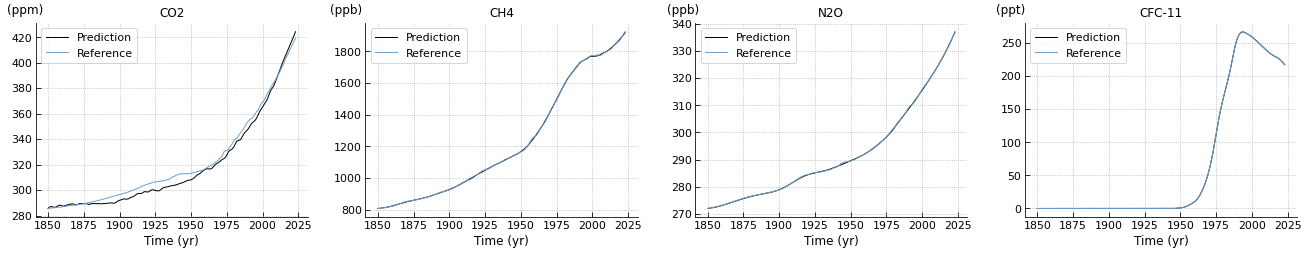

In [136]:
gas_order_plot = ['CO2', 'CH4', 'N2O', 'CFC-11']
map_conc_units = {'CO2': 'ppm', 'CH4': 'ppb', 'N2O': 'ppb'}

myplt.init_regular(
    len(gas_order_plot), col=4, kw_space={'height': 2.7},
)

kw_ylabel = {
    'rotation': 'horizontal',
    'x': 0., 'y': 1.03, 'ha': 'left', 'va': 'bottom',
}

for n, gas in enumerate(gas_order_plot):
    ax = myplt(n)

    vn = 'cco2' if gas == 'CO2' else f'ghg|{gas}'
    d1 = ret[vn]
    ax.plot(d1.index, d1, label='Prediction')

    d1 = df_conc.loc[year_base:2023, gas]
    ax.plot(d1.index, d1, label='Reference')

    ax.legend()
    ax.set_title(gas)
    ax.set_ylabel('({})'.format(map_conc_units.get(gas, 'ppt')), **kw_ylabel)
    ax.set_xlabel('Time (yr)')
    ax.grid()

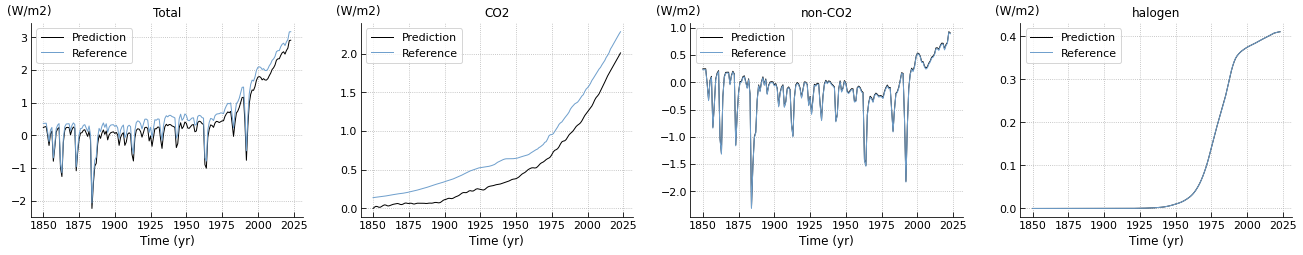

In [138]:
cat_order_plot = ['Total', 'CO2', 'non-CO2', 'halogen']

myplt.init_regular(
    len(gas_order_plot), col=4, kw_space={'height': 2.7},
)

for n, cat in enumerate(cat_order_plot):
    ax = myplt(n)

    vn = 'erf' if cat == 'Total' else f'erf|{cat}'
    d1 = ret[vn]
    ax.plot(d1.index, d1, label='Prediction')

    if cat == 'Total':
        d1 = erf_best_agg_ref.loc[year_base:2023, 'total']
    elif cat == 'non-CO2':
        d1 = (
            erf_best_agg_ref.loc[year_base:2023, 'total']
            - erf_best_agg_ref.loc[year_base:2023, 'CO2']
        )
    else:
        d1 = erf_best_agg_ref.loc[year_base:2023, cat]

    ax.plot(d1.index, d1, label='Reference')

    ax.legend()
    ax.set_title(cat)
    ax.set_ylabel('(W/m2)', **kw_ylabel)
    ax.set_xlabel('Time (yr)')
    ax.grid()

Note that large differences in the CO2 concentration do not much affect temperature response as the climate feedback parameter is calibrated to a relatively large value in this case.

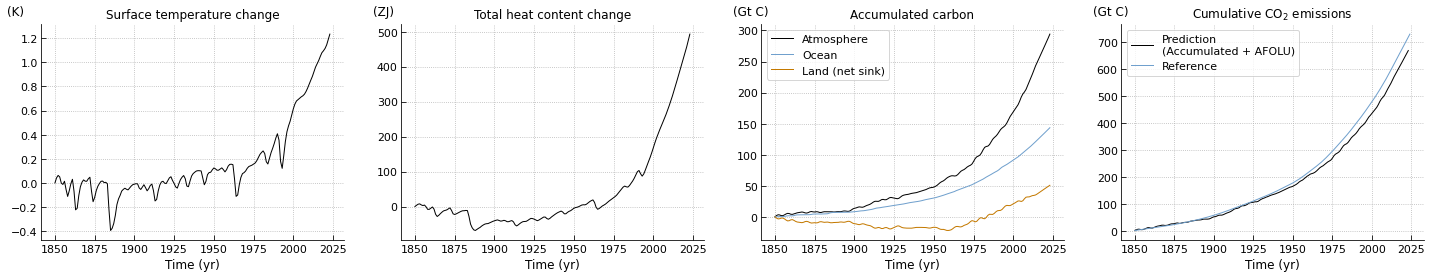

In [140]:
myplt.init_regular(4, col=4)

ax = myplt(0)
vn = 'tas'
d1 = ret[vn]
ax.plot(d1.index, d1)
ax.set_title('Surface temperature change')
ax.set_ylabel('(K)', **kw_ylabel)

ax = myplt(1)
vn = 'thc'
d1 = ret[vn]
ax.plot(d1.index, d1)
ax.set_title('Total heat content change')
ax.set_ylabel('(ZJ)', **kw_ylabel)

ax = myplt(2)
map_label = {
    'catm': 'Atmosphere',
    'coct': 'Ocean',
    'cbst': 'Land (net sink)',
}
for vn in ['catm', 'coct', 'cbst']:
    d1 = ret[vn]
    ax.plot(d1.index, d1, label=map_label[vn])

ax.legend()
ax.set_title('Accumulated carbon')
ax.set_ylabel('(Gt C)', **kw_ylabel)

ax = myplt(3)
d1 = ret[['catm', 'cbst', 'coct', 'ecum|AFOLU']].sum(axis=1)
ax.plot(d1.index, d1, label='Prediction\n(Accumulated + AFOLU)')
d1 = df_emis_co2_ref.cumsum().sum(axis=1)
ax.plot(d1.index, d1, label='Reference')
ax.legend()
ax.set_title('Cumulative CO$_2$ emissions')
ax.set_ylabel('(Gt C)', **kw_ylabel)

for n, ax in enumerate(myplt()):
    ax.set_xlabel('Time (yr)')
    ax.grid()

In [141]:
ds.close()

[2025-03-28 14:16:09 mce.core] INFO:in-memory file closed
